# Dementia Prediction Model Notebook
This notebook predicts dementia status using clinical data.

In [2]:
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt

from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    GroupShuffleSplit,
)

from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBClassifier

from catboost import CatBoostClassifier

from lightgbm import LGBMClassifier



## Load dataset
Read the dementia prediction dataset from CSV into a dataframe.

In [3]:
df = pd.read_csv("Dementia Prediction Dataset.csv", low_memory=False)

## Inspect raw data
Show the first rows to understand the columns and values.

In [4]:
df

,NACCID,NACCADC,PACKET,FORMVER,VISITMO,VISITDAY,VISITYR,NACCVNUM,NACCAVST,NACCNVST,...,NPATGAM1,NPATGAM2,NPATGAM3,NPATGAM4,NPATGAM5,NPATGFRN,NPATGFR1,NPATGFR2,NPATGFR3,NPATGFR4
0,NACC002909,186,I,3.0,12,28,2022,1,2,2,...,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4
1,NACC002909,186,F,3.0,1,23,2024,2,2,2,...,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4
2,NACC003487,186,I,3.0,11,15,2023,1,1,1,...,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4
3,NACC004352,186,I,3.0,10,5,2021,1,1,1,...,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4
4,NACC004687,186,I,3.0,11,14,2022,1,1,1,...,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195191,NACC998475,9661,F,2.0,11,6,2008,3,3,3,...,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4
195192,NACC999391,9661,I,1.0,3,2,2006,1,3,3,...,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4
195193,NACC999391,9661,F,1.0,5,17,2007,2,3,3,...,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4
195194,NACC999391,9661,F,2.0,3,27,2008,3,3,3,...,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4


## Target distribution
Check how many visits are labeled as demented or not.

In [5]:
df.DEMENTED.value_counts()

DEMENTED
0    137606
1     57590
Name: count, dtype: int64

## Select feature groups
Define demographic, health history, and family history columns.

In [6]:
# A1 demographics columns
a1_cols = [
    "NACCAGE", "SEX", "EDUC", "RACE", "RACESEC", "RACETER",
    "PRIMLANG", "MARISTAT", "RESIDENC", "NACCLIVS",
    "INDEPEND", "HANDED", "NACCREFR", "NACCREAS",
]

# A5 self-reported health history columns
a5_cols = [
    "CVHATT", "HATTMULT", "CVAFIB", "CVANGIO", "CVBYPASS", "CVPACDEF", "CVPACE",
    "CVCHF", "CVANGINA", "CVHVALVE", "CVOTHR",
    "CBSTROKE", "STROKMUL", "CBTIA", "TIAMULT",
    "DIABETES", "DIABTYPE", "HYPERTEN", "HYPERCHO",
    "PD", "SEIZURES", "TBI",
    "APNEA", "INSOMN", "DEP2YRS", "PTSD", "BIPOLAR", "ANXIETY",
    "TOBAC30", "TOBAC100", "SMOKYRS", "PACKSPER", "QUITSMOK",
    "ALCOCCAS", "ALCFREQ", "ABUSOTHR",
    "NACCBMI", 'HEIGHT', 'WEIGHT','THYROID','B12DEF','ARTHRIT','INCONTU'
]

# A3 family history columns
a3_cols = ["NACCFAM", "NACCMOM", "NACCDAD"]

# Combine all columns
selected_cols = a1_cols + a5_cols + a3_cols

# Define target column
target_col="DEMENTED"

# Extract only those columns
df_sel = df[selected_cols].copy()

In [7]:
#Check age statistics
df.NACCAGE.min(), df.NACCAGE.max()

(np.int64(18), np.int64(110))

## Define cleaning helpers
Create small functions to clean education and A5 flags.

In [8]:
def clean_educ(x):
    return np.nan if x == 99 else x

def a5_to_flag(s):
    """
    A5 coding:
    0 = No, 1 = Recent/active, 2 = Remote/inactive,
    9 = Unknown, -4 = Not available
    Convert (1) -> 1, (2) -> 2, (0) -> 0, unknown -> NaN.
    """
    return s.replace({1:1, 2:2, 0:0, 9:np.nan, -4:np.nan})

## Build final feature table
Engineer and encode features for modeling, including BMI and flags.

In [ ]:
# Create final feature dataframe
df_final = pd.DataFrame(index=df_sel.index)

# Age
df_final["AGE"] = df_sel["NACCAGE"]

# Basic demographics
df_final["SEX"] = df_sel["SEX"]
df_final["EDUC_YEARS"] = df_sel["EDUC"].apply(clean_educ)
df_final["HANDED"] = df_sel["HANDED"]
df_final["INDEPEND"] = df_sel["INDEPEND"]
df_final["NACCLIVS"] = df_sel["NACCLIVS"]

# Language
df_final["PRIMLANG"] = df_sel["PRIMLANG"]
df_final["IS_NON_ENGLISH_HOME"] = (df_sel["PRIMLANG"] != 1).astype(int)

# Marital status (one-hot)
df_final = pd.concat([df_final,
                      pd.get_dummies(df_sel["MARISTAT"], prefix="MARITAL", dtype=int)],
                     axis=1)

# Residence type (one-hot)
df_final = pd.concat([df_final,
                      pd.get_dummies(df_sel["RESIDENC"], prefix="RESIDENCE", dtype=int)],
                     axis=1)

# Race
df_final["RACE"] = df_sel["RACE"]
df_final["IS_MULTIRACIAL"] = (
    df_sel["RACESEC"].isin([1,2,3,4,5,50]) | 
    df_sel["RACETER"].isin([1,2,3,4,5,50])
).astype(int)
df_final["RACE_OTHER"] = (df_sel["RACE"] == 50).astype(int)

# One-hot encode primary race
df_final = pd.concat([df_final,
                      pd.get_dummies(df_sel["RACE"], prefix="RACE", dtype=int)],
                     axis=1)


# A5 variables as flag features

for col in a5_cols:
    
    if col == "DIABTYPE":
        # Keep DIABTYPE as a numeric category (optional)
        df_final["DIABTYPE"] = df_sel["DIABTYPE"].replace({9:np.nan, -4:np.nan})
    else:
        df_final[col + "_FLAG"] = a5_to_flag(df_sel[col])

# Extra smoking-related features
df_final["SMOKED_100PLUS"] = df_sel["TOBAC100"].replace({0:0, 1:1, 9:np.nan, -4:np.nan})

df_final["SMOKED_LAST_30D"] = df_sel["TOBAC30"].replace({0:0,1:1, 9:np.nan, -4:np.nan})

# Body mass index (BMI)
df_final["BMI"] = df_sel["NACCBMI"].replace({888.8:np.nan,-4:np.nan})

# Fill missing BMI by calculating BMI where HEIGHT and WEIGHT exist.
df_sel["HEIGHT"] = df_sel["HEIGHT"].replace({88.8:np.nan,-4:np.nan})
df_sel["WEIGHT"] = df_sel["WEIGHT"].replace({888.0:np.nan,-4:np.nan})

# BMI formula: (weight in lbs × 703) / (height in inches)^2
df_final.loc[
    df_final["BMI"].isna() &
    df_sel["HEIGHT"].notna() &
    df_sel["WEIGHT"].notna(),
    "BMI"
 ] =  (df_sel["WEIGHT"] * 703) / (df_sel["HEIGHT"] ** 2)

# A3 family history flags (optional but included)

for col in a3_cols:
    df_final[col + "_FLAG"] = df_sel[col].replace({0:0,1:1,9:np.nan,-4:np.nan})





## Define X and y
Create the feature matrix X and target vector y.

In [10]:
y=df[target_col]
X=df_final.copy()

## Check shapes
Confirm the dimensions of X and y before splitting.

In [11]:
print("X:", X.shape)
print("y:", y.shape)

df_final


X: (195196, 77)
y: (195196,)


,AGE,SEX,EDUC_YEARS,HANDED,INDEPEND,NACCLIVS,PRIMLANG,IS_NON_ENGLISH_HOME,MARITAL_1,MARITAL_2,...,THYROID_FLAG,B12DEF_FLAG,ARTHRIT_FLAG,INCONTU_FLAG,SMOKED_100PLUS,SMOKED_LAST_30D,BMI,NACCFAM_FLAG,NACCMOM_FLAG,NACCDAD_FLAG
0,70,1,16.0,2,1,4,1,0,1,0,...,1.0,0.0,0.0,1.0,0.0,0.0,32.4,1.0,0.0,0.0
1,71,1,16.0,2,1,2,1,0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,30.7,1.0,0.0,0.0
2,66,1,16.0,2,1,2,1,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,23.7,0.0,0.0,0.0
3,63,2,16.0,2,2,2,2,1,1,0,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
4,77,1,12.0,2,1,1,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,19.0,NaN,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195191,72,2,13.0,2,2,4,1,0,0,0,...,0.0,0.0,NaN,2.0,0.0,0.0,NaN,NaN,0.0,NaN
195192,87,1,13.0,2,1,1,1,0,0,1,...,0.0,1.0,NaN,1.0,1.0,0.0,26.8,NaN,0.0,0.0
195193,89,1,13.0,2,3,1,1,0,0,1,...,0.0,2.0,NaN,2.0,1.0,0.0,27.1,NaN,0.0,0.0
195194,89,1,13.0,2,3,1,1,0,0,1,...,0.0,1.0,NaN,1.0,1.0,0.0,25.5,NaN,0.0,0.0


## Participant overview
Count how many unique participants and repeat visits exist.

In [12]:
total = df["NACCID"].nunique()
duplicates = (df["NACCID"].value_counts() > 1).sum()

print("Total unique participants:", total)
print("Participants with more than one visit:", duplicates)

Total unique participants: 52537
Participants with more than one visit: 35671


## Grouped train, validation, and test split
Split visits by participant ID so the same person is not in multiple sets.

In [13]:
# 1. Get participant IDs

groups = df.loc[df.index, "NACCID"].reset_index(drop=True)

# 2. First split: Train vs Temp (Val+Test)

gss1 = GroupShuffleSplit(n_splits=1, test_size=0.30, random_state=42)

train_idx, temp_idx = next(gss1.split(X, y, groups=groups))

X_train = X.iloc[train_idx]
y_train = y.iloc[train_idx]

X_temp  = X.iloc[temp_idx]
y_temp  = y.iloc[temp_idx]
groups_temp = groups.iloc[temp_idx]


# 3. Second split: Validation vs Test

gss2 = GroupShuffleSplit(n_splits=1, test_size=0.50, random_state=42)

val_idx, test_idx = next(gss2.split(X_temp, y_temp, groups=groups_temp))

X_val  = X_temp.iloc[val_idx]
y_val  = y_temp.iloc[val_idx]

X_test = X_temp.iloc[test_idx]
y_test = y_temp.iloc[test_idx]

# 4. Print results

print("Train:", X_train.shape, y_train.shape)
print("Validation:", X_val.shape, y_val.shape)
print("Test:", X_test.shape, y_test.shape)

print("\nTarget distribution:")
print("Train:\n", y_train.value_counts(normalize=True))
print("Val:\n",   y_val.value_counts(normalize=True))
print("Test:\n",  y_test.value_counts(normalize=True))

print("\nUnique participants:")
print("Train:", len(groups.iloc[train_idx].unique()))
print("Val:",   len(groups_temp.iloc[val_idx].unique()))
print("Test:",  len(groups_temp.iloc[test_idx].unique()))


Train: (136285, 77) (136285,)
Validation: (29707, 77) (29707,)
Test: (29204, 77) (29204,)

Target distribution:
Train:
 DEMENTED
0    0.703313
1    0.296687
Name: proportion, dtype: float64
Val:
 DEMENTED
0    0.708385
1    0.291615
Name: proportion, dtype: float64
Test:
 DEMENTED
0    0.709184
1    0.290816
Name: proportion, dtype: float64

Unique participants:
Train: 36775
Val: 7881
Test: 7881


## Evaluation helper
Define a function to compute AUC and accuracy on validation and test sets.

In [14]:
def model_evaluation(model_name, model, X_val, y_val, X_test, y_test):
    # Validation set evaluation
    val_proba = model.predict_proba(X_val)[:, 1]
    val_pred = (val_proba > 0.5).astype(int)

    val_auc = roc_auc_score(y_val, val_proba)
    val_acc = accuracy_score(y_val, val_pred)

    # Test set evaluation
    test_proba = model.predict_proba(X_test)[:, 1]
    test_pred = (test_proba > 0.5).astype(int)

    test_auc = roc_auc_score(y_test, test_proba)
    test_acc = accuracy_score(y_test, test_pred)

    print("====================================")
    print(f"   {model_name} FINAL EVALUATION    ")
    print("====================================")
    print(f"Validation AUC: {val_auc:.4f}")
    print(f"Validation ACC: {val_acc:.4f}")
    print("------------------------------------")
    print(f"Test AUC:       {test_auc:.4f}")
    print(f"Test ACC:       {test_acc:.4f}")
    print("====================================")



    
   

## Training helper
Create a reusable function to run hyperparameter search and fit the final model.

In [15]:
def train_model(base_estimator, param_grid, X_train, y_train, search_type="grid", scoring="roc_auc", cv=3, n_iter=40, verbose=2):
    if search_type == "grid":
        search = GridSearchCV(
            estimator=base_estimator,
            param_grid=param_grid,
            cv=cv,
            scoring=scoring,
            verbose=verbose,
            n_jobs=-1,
        )
    elif search_type == "random":
        search = RandomizedSearchCV(
            estimator=base_estimator,
            param_distributions=param_grid,
            n_iter=n_iter,
            scoring=scoring,
            cv=cv,
            verbose=verbose,
            random_state=42,
            n_jobs=-1,
        )

    search.fit(X_train, y_train)
    best_params = search.best_params_

    base_params = base_estimator.get_params()
    base_params.update(best_params)

    final_model = base_estimator.__class__(
        **base_params,
    )

    final_model.fit(X_train, y_train)

    return final_model, search

## Explainability & Insights 

In [16]:
def importance(model):
    #Check Importance of columns 
    importance_df=pd.DataFrame({
    'featura' : X.columns,
    'importance' : model.feature_importances_
    }).sort_values('importance',ascending=False)

    return importance_df.head(10)

    


## Use SHAP to understand the final model's predictions

In [17]:
shap.initjs() # Initialize SHAP JS

def explain_tree_model(model_name, model, X_val):
    print("\n====================================")
    print(f" SHAP explanation for {model_name}")
    print("====================================")

    X_sample = X_val.sample(1000, random_state=42).copy()

    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_sample, check_additivity=False)

    if isinstance(shap_values, list) and len(shap_values) > 1:
        shap_to_plot = shap_values[1]
    else:
        shap_to_plot = shap_values

    # Summary dot plot: feature impact and direction 
    print("\nSHAP Summary Plot (Feature Impact)")
    plt.figure(figsize=(10, 5))
    shap.summary_plot(shap_to_plot, X_sample, plot_type="dot", show=False)
    plt.show()
    
    # Summary bar plot: global feature importance
    print("\nSHAP Bar Plot (Global Importance)")
    plt.figure(figsize=(10, 8))
    shap.summary_plot(shap_to_plot, X_sample, plot_type="bar", show=False)
    plt.show()



## Random Forest model
Tune and train a Random Forest classifier.

In [18]:
rf_grid = {
    "n_estimators": [200, 300],
    "max_depth": [15, 20, 25],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "class_weight": ["balanced"]
    }

rf_model = RandomForestClassifier(n_jobs=-1, random_state=42)

rf_final, grid_rf = train_model(
    base_estimator=rf_model,
    param_grid=rf_grid,
    X_train=X_train,
    y_train=y_train,
    search_type="grid",
    scoring="roc_auc",
    cv=3,
    verbose=2,
)

print("\nBest RF Params:", grid_rf.best_params_)
print("Best RF CV AUC:", grid_rf.best_score_)

Fitting 3 folds for each of 54 candidates, totalling 162 fits

Best RF Params: {'class_weight': 'balanced', 'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 300}
Best RF CV AUC: 0.9253740762779671


## Evaluate Random Forest
Evaluate performance of the tuned Random Forest.

In [19]:
#Evaluate Random Forest Model 
model_evaluation("Random Forest", rf_final, X_val, y_val, X_test, y_test)

   Random Forest FINAL EVALUATION    
Validation AUC: 0.9348
Validation ACC: 0.9015
------------------------------------
Test AUC:       0.9343
Test ACC:       0.8999


In [20]:
importance(rf_final)

,featura,importance
4,INDEPEND,0.660132
5,NACCLIVS,0.045894
73,BMI,0.028368
66,NACCBMI_FLAG,0.026963
2,EDUC_YEARS,0.022878
0,AGE,0.022163
54,DEP2YRS_FLAG,0.021763
18,RESIDENCE_4,0.012080
70,INCONTU_FLAG,0.011593
17,RESIDENCE_3,0.009473


## XGBoost model
Tune and train an XGBoost classifier.

In [21]:
#XGBOOST PARAMETER SEARCH SPACE 

xgb_param_dist = {
    "n_estimators": [300, 400, 500],
    "max_depth": [3, 4, 5, 6],
    "learning_rate": [0.01, 0.03, 0.05, 0.1],
    "subsample": [0.6, 0.7, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.7, 0.8, 1.0],
    "gamma": [0, 1, 5],
    "min_child_weight": [1, 3, 5, 7],
    "reg_alpha": [0, 0.01, 0.1],
    "reg_lambda": [1, 1.5, 2.0]
}

# 2. Create base XGB model

xgb_base = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    tree_method="hist",     
    n_jobs=-1,
    random_state=42
)

# 3. Randomized Search and final model training via helper

xgb_final, rand_xgb = train_model(
    base_estimator=xgb_base,
    param_grid=xgb_param_dist,
    X_train=X_train,
    y_train=y_train,
    search_type="random",
    scoring="roc_auc",
    cv=3,
    n_iter=40,
    verbose=2,
)

print("\nBest XGB Params:", rand_xgb.best_params_)
print("Best XGB CV AUC:", rand_xgb.best_score_)

Fitting 3 folds for each of 40 candidates, totalling 120 fits

Best XGB Params: {'subsample': 0.7, 'reg_lambda': 1.5, 'reg_alpha': 0.01, 'n_estimators': 300, 'min_child_weight': 3, 'max_depth': 5, 'learning_rate': 0.03, 'gamma': 0, 'colsample_bytree': 1.0}
Best XGB CV AUC: 0.9293104789546871


## Evaluate XGBoost
Evaluate performance of the tuned XGBoost model.

In [22]:
#Evaluate XGB Model
model_evaluation("XGBoost", xgb_final, X_val, y_val, X_test, y_test)

   XGBoost FINAL EVALUATION    
Validation AUC: 0.9372
Validation ACC: 0.9035
------------------------------------
Test AUC:       0.9352
Test ACC:       0.9006


In [23]:
importance(xgb_final)

,featura,importance
4,INDEPEND,0.677057
54,DEP2YRS_FLAG,0.020752
1,SEX,0.010812
5,NACCLIVS,0.009934
49,PD_FLAG,0.008356
0,AGE,0.006904
62,QUITSMOK_FLAG,0.006890
18,RESIDENCE_4,0.006841
8,MARITAL_1,0.006675
27,RACE_5,0.006246



 SHAP explanation for XGBoost

SHAP Summary Plot (Feature Impact)


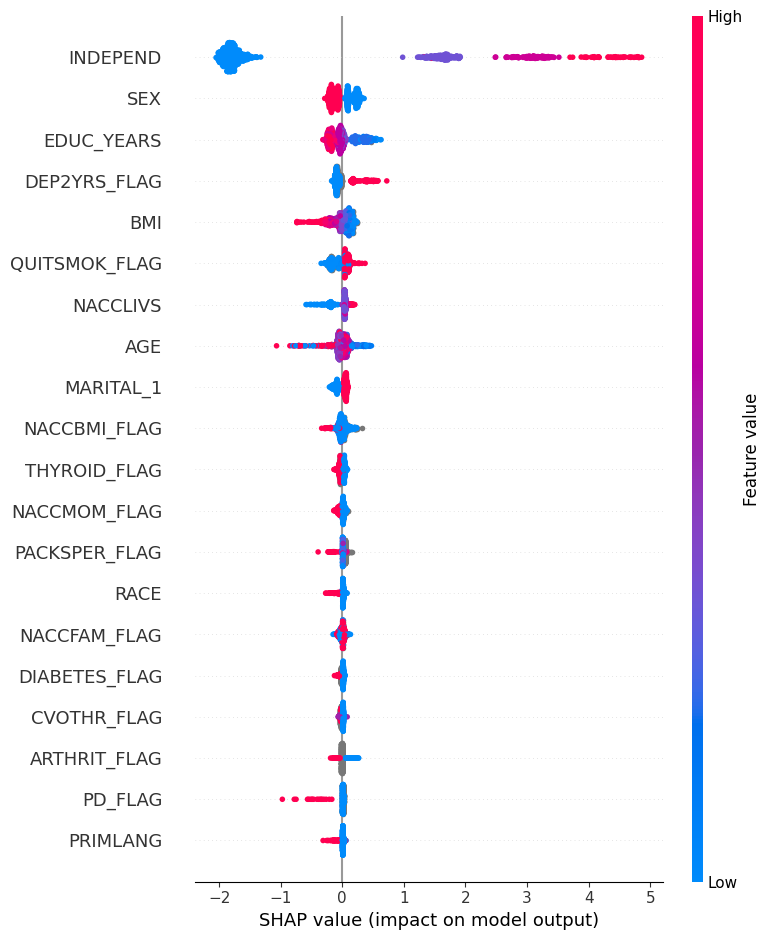


SHAP Bar Plot (Global Importance)


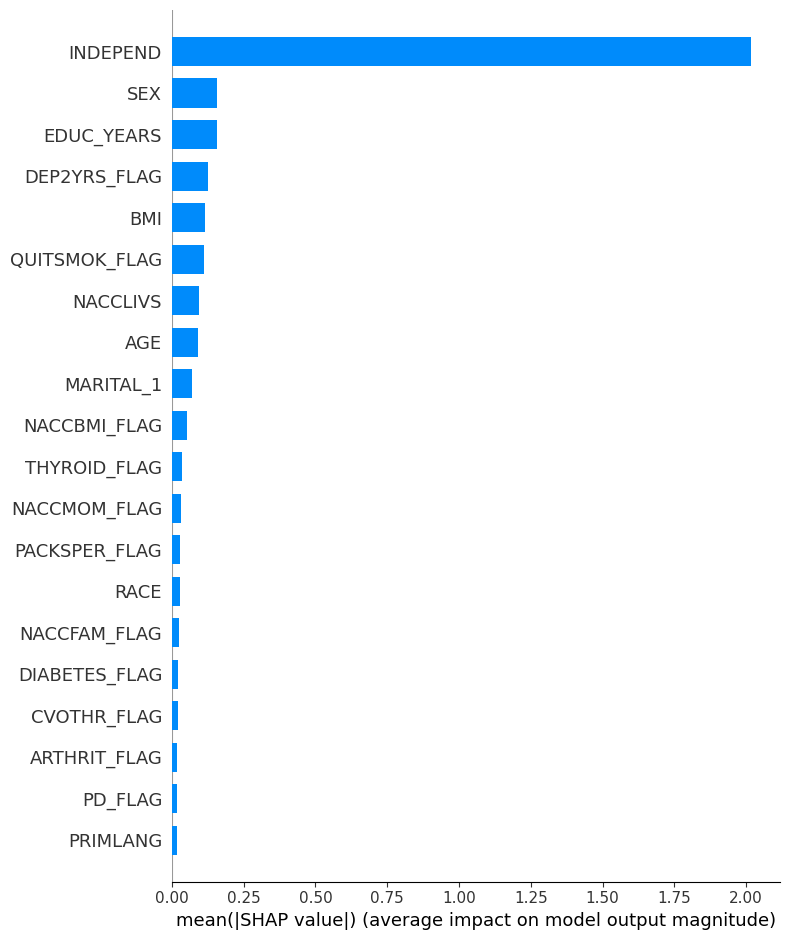

In [24]:
explain_tree_model("XGBoost", xgb_final, X_val)

## CatBoost model
Tune and train a CatBoost classifier.

In [25]:
# 1. Define Search Space for CatBoost

cat_param_dist = {
    "iterations": [300, 500, 700, 900],
    "depth": [4, 5, 6, 7, 8],
    "learning_rate": [0.01, 0.03, 0.05, 0.07],
    "l2_leaf_reg": [1, 3, 5, 7, 9],
    "subsample": [0.6, 0.7, 0.8, 1.0],
    "border_count": [32, 64, 128, 254]
}

# 2. Base CatBoost Model

cat_base = CatBoostClassifier(
    loss_function="Logloss",
    eval_metric="AUC",
    verbose=0,
    thread_count=-1,
    random_state=42
    
)

# 3. Random Search and final model training via helper

cat_final, cat_search = train_model(
    base_estimator=cat_base,
    param_grid=cat_param_dist,
    X_train=X_train,
    y_train=y_train,
    search_type="random",
    scoring="roc_auc",
    cv=3,
    n_iter=40,
    verbose=2,
)

print("Best CatBoost Params:", cat_search.best_params_)
print("Best CV AUC:", cat_search.best_score_)

Fitting 3 folds for each of 40 candidates, totalling 120 fits
Best CatBoost Params: {'subsample': 1.0, 'learning_rate': 0.03, 'l2_leaf_reg': 9, 'iterations': 500, 'depth': 8, 'border_count': 254}
Best CV AUC: 0.929217551751445


## Evaluate CatBoost
Evaluate performance of the tuned CatBoost model.

In [26]:
#Evaluate CatBoost Model
model_evaluation("CatBoost", cat_final, X_val, y_val, X_test, y_test)

   CatBoost FINAL EVALUATION    
Validation AUC: 0.9374
Validation ACC: 0.9037
------------------------------------
Test AUC:       0.9364
Test ACC:       0.9008


In [27]:
importance(cat_final)

,featura,importance
4,INDEPEND,60.076090
0,AGE,5.154875
2,EDUC_YEARS,3.647745
1,SEX,2.453237
73,BMI,2.241823
54,DEP2YRS_FLAG,2.128051
74,NACCFAM_FLAG,2.014041
66,NACCBMI_FLAG,1.762006
5,NACCLIVS,1.726481
20,RACE,0.949850


## LightGBM model
Tune and train a LightGBM classifier.

In [28]:
# 1. LightGBM Search Space

lgb_param_dist = {
    "n_estimators": [300, 500, 800],
    "max_depth": [-1, 4, 6, 8, 10],
    "learning_rate": [0.01, 0.03, 0.05, 0.1],
    "num_leaves": [20, 30, 40, 50, 60],
    "subsample": [0.6, 0.7, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.7, 0.8, 1.0],
    "reg_alpha": [0, 0.01, 0.1],
    "reg_lambda": [0.1, 0.3, 0.5, 1.0]
}

# 2. Base Model

lgb_base = LGBMClassifier(
    objective="binary",
    class_weight="balanced",
    n_jobs=-1,
    random_state=42
)

# 3. Randomized Search and final model training via helper

lgb_final, lgb_search = train_model(
    base_estimator=lgb_base,
    param_grid=lgb_param_dist,
    X_train=X_train,
    y_train=y_train,
    search_type="random",
    scoring="roc_auc",
    cv=3,
    n_iter=40,
    verbose=2,
)

print("Best LGBM Params:", lgb_search.best_params_)
print("Best LGBM CV AUC:", lgb_search.best_score_)

Fitting 3 folds for each of 40 candidates, totalling 120 fits
[LightGBM] [Info] Number of positive: 40434, number of negative: 95851
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011726 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1056
[LightGBM] [Info] Number of data points in the train set: 136285, number of used features: 77
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Info] Number of positive: 40434, number of negative: 95851
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012096 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1056
[LightGBM] [Info] Number of data points in the tra

## Evaluate LightGBM
Evaluate performance of the tuned LightGBM model.

In [29]:
#Evaluate LightGBM Model
model_evaluation("LightGBM", lgb_final, X_val, y_val, X_test, y_test)

   LightGBM FINAL EVALUATION    
Validation AUC: 0.9383
Validation ACC: 0.9015
------------------------------------
Test AUC:       0.9362
Test ACC:       0.8999


In [30]:
importance(lgb_final)

,featura,importance
0,AGE,3621
66,NACCBMI_FLAG,2207
2,EDUC_YEARS,2179
73,BMI,1941
4,INDEPEND,1886
62,QUITSMOK_FLAG,1408
60,SMOKYRS_FLAG,984
74,NACCFAM_FLAG,834
75,NACCMOM_FLAG,772
20,RACE,756


## Stacking ensemble
Combine predictions from all four models using logistic regression as a meta model.

In [31]:
# 1. Get PREDICTIONS for VALIDATION SET

rf_val_proba  = rf_final.predict_proba(X_val)[:, 1]
xgb_val_proba = xgb_final.predict_proba(X_val)[:, 1]
lgb_val_proba = lgb_final.predict_proba(X_val)[:, 1]
cat_val_proba = cat_final.predict_proba(X_val)[:, 1]

# Build meta-feature matrix
stack_val_X = np.column_stack([
    rf_val_proba,
    xgb_val_proba,
    lgb_val_proba,
    cat_val_proba
])

# 2. Train META-MODEL (Logistic Regression)

meta_model = LogisticRegression(max_iter=1000)
meta_model.fit(stack_val_X, y_val)

# 3. Evaluate stacking on VALIDATION SET
val_meta_proba = meta_model.predict_proba(stack_val_X)[:, 1]
val_auc = roc_auc_score(y_val, val_meta_proba)

print("\n============================================")
print("Validation AUC (4-Model Stacking):", round(val_auc, 4))
print("============================================")

# 4. Get predictions on TEST SET
rf_test_proba  = rf_final.predict_proba(X_test)[:, 1]
xgb_test_proba = xgb_final.predict_proba(X_test)[:, 1]
lgb_test_proba = lgb_final.predict_proba(X_test)[:, 1]
cat_test_proba = cat_final.predict_proba(X_test)[:, 1]

# Build test meta-feature set
stack_test_X = np.column_stack([
    rf_test_proba,
    xgb_test_proba,
    lgb_test_proba,
    cat_test_proba
])

# 5. Final TEST SET prediction
test_meta_proba = meta_model.predict_proba(stack_test_X)[:, 1]
test_auc = roc_auc_score(y_test, test_meta_proba)

print("\n============================================")
print("Test AUC (4-Model Stacking):", round(test_auc, 4))
print("============================================")



Validation AUC (4-Model Stacking): 0.9382

Test AUC (4-Model Stacking): 0.9369
